In [100]:
import networkx as nx
from node2vec import Node2Vec
import numpy as np
import random
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

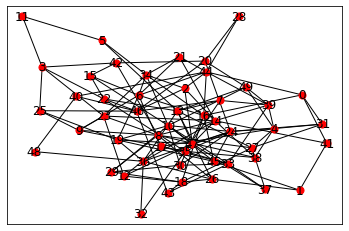

In [15]:
# Create a graph
graph = nx.fast_gnp_random_graph(n=50, p=0.1)


nx.draw_networkx(graph, with_labels=True, node_size=50, node_color='r')

In [84]:
# Extract 10% of existing edges for testing
test_edge_list_split = random.sample(graph.edges(), int(0.1 * graph.number_of_edges()))
test_edges = list(random.sample(graph.edges(), int(0.1 * graph.number_of_edges())))

In [85]:
# Extract 10% of non-existing edges for testing
test_edge_false_list_split = random.sample(list(nx.non_edges(graph)), int(0.1 * len(list(nx.non_edges(graph)))))
test_edges_false = list(test_edge_false_list_split)

In [78]:
# Create training by removing the extracted edges from the graph
training_graph = graph.copy()
training_graph.remove_edges_from(test_edge_list_split)

# lists of positive and negative edges for training
train_edges = training_graph.edges()
train_edges_false = list(set(nx.non_edges(training_graph)) - set(test_edge_false))

# check that the training graph is connected
nx.is_connected(training_graph)


True

*To be added*: 10-folder cross validation for hyperparameter (here, p and q) setting

In [79]:
#https://github.com/eliorc/node2vec
    
#Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(training_graph, dimensions=64, walk_length=30, num_walks=200, workers=4)  # Use temp_folder for big graphs

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

# Look for most similar nodes
#model.wv.most_similar('2')  # Output node names are always strings

In [80]:
# Create node embeddings matrix (rows = nodes, columns = embedding features)
emb_list = []
for node_index in range(0, adj_sparse.shape[0]):
    node_str = str(node_index)
    node_emb = model[node_str]
    emb_list.append(node_emb)
emb_matrix = np.vstack(emb_list)
# print(emb_matrix)

<ipython-input-80-76d21247562d>:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  node_emb = model[node_str]


In [48]:
# # Embed edges using Hadamard method
# from node2vec.edges import HadamardEmbedder

# edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

# # Look for embeddings on the fly - here we pass normal tuples
# print(edges_embs[('11', '5')])
# print(edges_embs[('11', '48')])

In [18]:
# Get all edges in a separate KeyedVectors instance - use with caution could be huge for big networks
# edges_kv = edges_embs.as_keyed_vectors()

Generating edge features: 100%|██████████| 1275/1275.0 [00:00<00:00, 52586.04it/s]


In [19]:
# edges_kv.most_similar(str(('11', '3')))

[("('3', '3')", 0.8713076710700989),
 ("('22', '3')", 0.799231231212616),
 ("('3', '5')", 0.7968197464942932),
 ("('25', '3')", 0.7811664342880249),
 ("('11', '11')", 0.7761228084564209),
 ("('11', '22')", 0.7716590762138367),
 ("('23', '3')", 0.7573121786117554),
 ("('11', '25')", 0.7416701912879944),
 ("('3', '42')", 0.7076650857925415),
 ("('11', '23')", 0.7059170007705688)]

In [13]:
# print(edges_kv[])

In [81]:
# Generate bootstrapped edge embeddings (as is done in node2vec paper)
    # Edge embedding for (v1, v2) = hadamard product of node embeddings for v1, v2
def get_edge_embeddings(edge_list):
    embs = []
    for edge in edge_list:
        node1 = edge[0]
        node2 = edge[1]
        emb1 = emb_matrix[node1]
        emb2 = emb_matrix[node2]
        edge_emb = np.multiply(emb1, emb2)
        embs.append(edge_emb)
    embs = np.array(embs)
    return embs

In [47]:
# print(train_edges)
# print(train_edges_false)

In [82]:
# Train-set edge embeddings
pos_train_edge_embs = get_edge_embeddings(train_edges)
neg_train_edge_embs = get_edge_embeddings(train_edges_false)
train_edge_embs = np.concatenate([pos_train_edge_embs, neg_train_edge_embs])

# Create train-set edge labels: 1 = real edge, 0 = false edge
train_edge_labels = np.concatenate([np.ones(len(train_edges)), np.zeros(len(train_edges_false))])

In [88]:
# Test-set edge embeddings, labels
pos_test_edge_embs = get_edge_embeddings(test_edges)
neg_test_edge_embs = get_edge_embeddings(test_edges_false)
test_edge_embs = np.concatenate([pos_test_edge_embs, neg_test_edge_embs])

# Create val-set edge labels: 1 = real edge, 0 = false edge
test_edge_labels = np.concatenate([np.ones(len(test_edges)), np.zeros(len(test_edges_false))])

In [87]:
# Train logistic regression classifier on train-set edge embeddings
from sklearn.linear_model import LogisticRegression
edge_classifier = LogisticRegression(random_state=0)
edge_classifier.fit(train_edge_embs, train_edge_labels)

LogisticRegression(random_state=0)

In [ ]:

# # Val-set edge embeddings, labels
# pos_val_edge_embs = get_edge_embeddings(val_edges)
# neg_val_edge_embs = get_edge_embeddings(val_edges_false)
# val_edge_embs = np.concatenate([pos_val_edge_embs, neg_val_edge_embs])
# val_edge_labels = np.concatenate([np.ones(len(val_edges)), np.zeros(len(val_edges_false))])

# Test-set edge embeddings, labels
pos_test_edge_embs = get_edge_embeddings(test_edges)
neg_test_edge_embs = get_edge_embeddings(test_edges_false)
test_edge_embs = np.concatenate([pos_test_edge_embs, neg_test_edge_embs])

# Create test-set edge labels: 1 = real edge, 0 = false edge
test_edge_labels = np.concatenate([np.ones(len(test_edges)), np.zeros(len(test_edges_false))])

In [98]:
# Predicted edge scores: probability of being of class "1" (real edge)
test_preds = edge_classifier.predict_proba(test_edge_embs)[:, 1]
test_roc = roc_auc_score(test_edge_labels, test_preds)
test_ap = average_precision_score(test_edge_labels, test_preds)

In [93]:
print('node2vec Test ROC score: ', str(test_roc))
print('node2vec Test AP score: ', str(test_ap))

node2vec Test ROC score:  0.7953422724064926
node2vec Test AP score:  0.5923891436083253


In [103]:
# from gae.preprocessing import mask_test_edges
# np.random.seed(0) # make sure train-test split is consistent between notebooks
# adj_sparse = nx.to_scipy_sparse_matrix(graph)

# # Perform train-test split
# adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
#     test_edges, test_edges_false = mask_test_edges(adj_sparse, test_frac=.3, val_frac=.1)
# g_train = nx.from_scipy_sparse_matrix(adj_train) # new graph object with only non-hidden edges